# Three-phase line analyzer for non-linear systems

In [2]:
import numpy as np
from daqthreephi import DataGen
import matplotlib.pyplot as plt

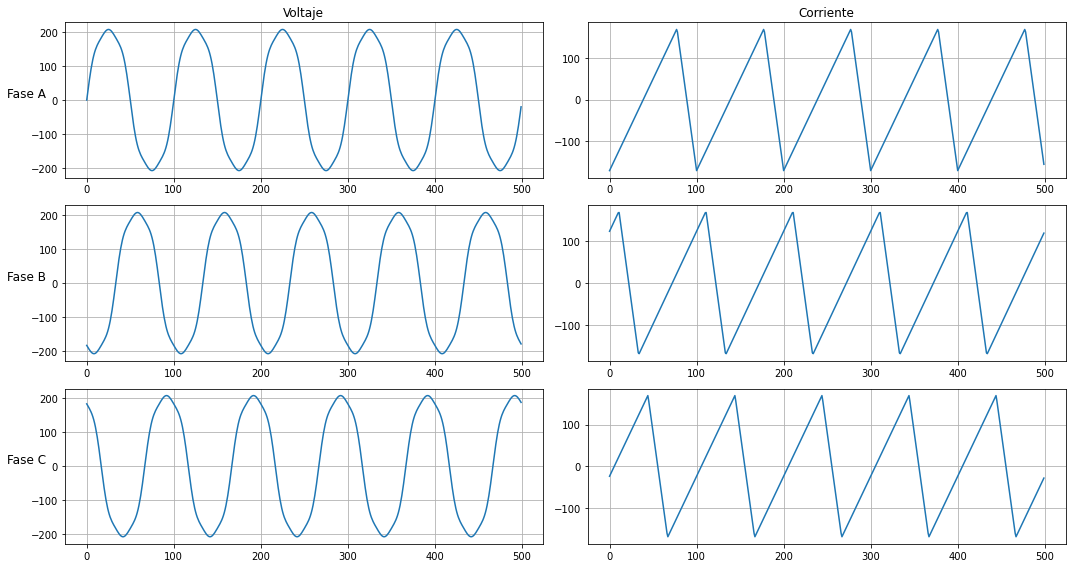

In [3]:
system = DataGen(60)
system.plot()

In [8]:
voltages, currents = system.get_data()
v1 = voltages[0]
v2 = voltages[1]
v3 = voltages[2]

v3.shape

(500,)